In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
models = {'SVM': SVC(),
          'RandomForest': RandomForestClassifier(),
          #"GradientBoosting": GradientBoostingClassifier(),
          "KNN": KNeighborsClassifier(),
          "GaussianNB": GaussianNB()}

In [4]:
def build_models(X_train, X_test, y_train, y_test, models: dict):
    score = {}
    class_report = {}
    for model_name in models.keys():
        model = models.get(model_name)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        accuracy = accuracy_score(pred, y_test)
        f1  = f1_score(pred, y_test, average='weighted')
        recall = recall_score(pred, y_test, average='weighted')
        precision = precision_score(pred, y_test, average='weighted')

        score[model_name] = [accuracy, f1, recall, precision]
        class_report[model_name] = pd.DataFrame(classification_report(y_test, pred, output_dict=True)).transpose()
       
    return pd.DataFrame(score, index=['accuracy', 'F1', 'Recall', 'Precision']), class_report


In [ ]:
data_train = pd.read_csv(r'..\GDCdata\data_processed\lasso\train\data_train_ls.csv')
data_test = pd.read_csv(r'..\GDCdata\data_processed\lasso\test\data_test_ls.csv')

X_train = data_train.drop(columns=['Unnamed: 0', 'label'])
X_test = data_test.drop(columns=['Unnamed: 0', 'label'])

y_train = data_train['label'].values
y_test = data_test['label'].values

In [ ]:
X_test.head()

In [ ]:
lb = LabelEncoder()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [ ]:
res, class_report = build_models(X_train, X_test, y_train, y_test, models)

In [ ]:
class_report['SVM']

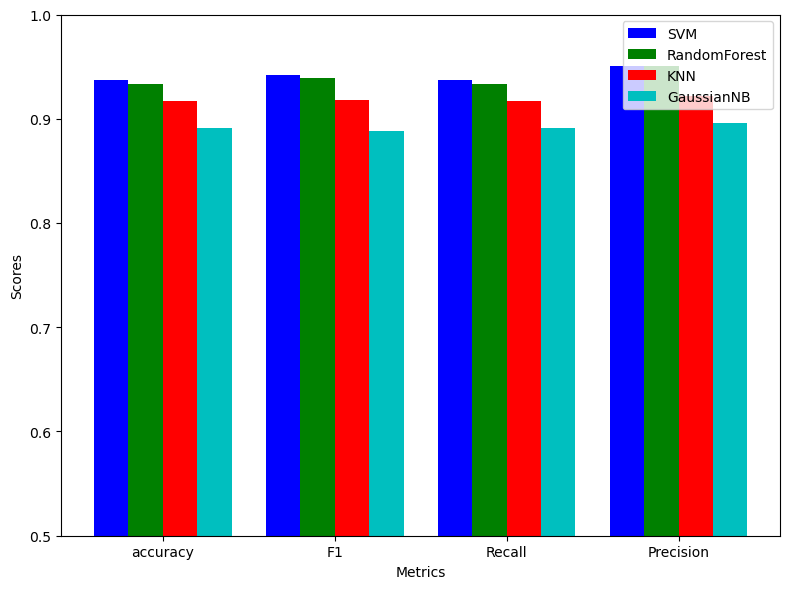

In [53]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 6))
bar_width = 0.2
x = np.arange(len(res.index))  

plt.bar(x, res['SVM'], width=bar_width, label='SVM', color='b', align='center')
plt.bar(x + bar_width, res['RandomForest'], width=bar_width, label='RandomForest', color='g', align='center')
plt.bar(x + 2 * bar_width, res['KNN'], width=bar_width, label='KNN', color='r', align='center')
plt.bar(x + 3 * bar_width, res['GaussianNB'], width=bar_width, label='GaussianNB', color='c', align='center')


plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(x + 1.5 * bar_width, res.index) 
plt.ylim(0.5, 1)
plt.legend()


plt.tight_layout()


In [ ]:
import matplotlib.pyplot as plt

df = class_report['SVM'].iloc[:33]
df.index = range(33)


plt.figure(figsize=(12, 7))
width = 0.2 

plt.bar(df.index - width, df['precision'], width, label='Precision', color='blue')
plt.bar(df.index, df['recall'], width, label='Recall', color='orange')
plt.bar(df.index + width, df['f1-score'], width, label='F1 Score', color='green')

plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(df.index, lb.inverse_transform(df.index), rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.05)

plt.show()

## Tối ưu hóa tham số


In [26]:
models = {'SVM': SVC(),
          'RandomForest': RandomForestClassifier(),
          #"GradientBoosting": GradientBoostingClassifier(),
          "KNN": KNeighborsClassifier(),
          "GaussianNB": GaussianNB()}

param_grids = {
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': [1e-3, 1e-4, 'scale', 'auto']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    },
    'KNN': {
        'n_neighbors': [5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2] # 1 for Manhattan, 2 for Euclidean
    }, 
    'GaussianNB':{
        'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]
    }
}


In [23]:
def  optimizer_ml(X_train, X_test, y_train, y_test, models, param_grids):

    results = []
    class_report = {}
    for model_name in models.keys():
        grid = GridSearchCV(models.get(model_name), param_grids.get(model_name), refit = True, verbose = 2, n_jobs=10) 
        grid.fit(X_train, y_train) 
        model = grid.best_estimator_
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results.append({
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average='weighted'),
            "Recall": recall_score(y_test, y_pred, average='weighted'),
            "F1 score": f1_score(y_test, y_pred, average='weighted')
        })
        
        class_report[model_name] = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

    return pd.DataFrame(results), class_report

In [ ]:
res, class_report = optimizer_ml(X_train, X_test, y_train, y_test, models, param_grids)

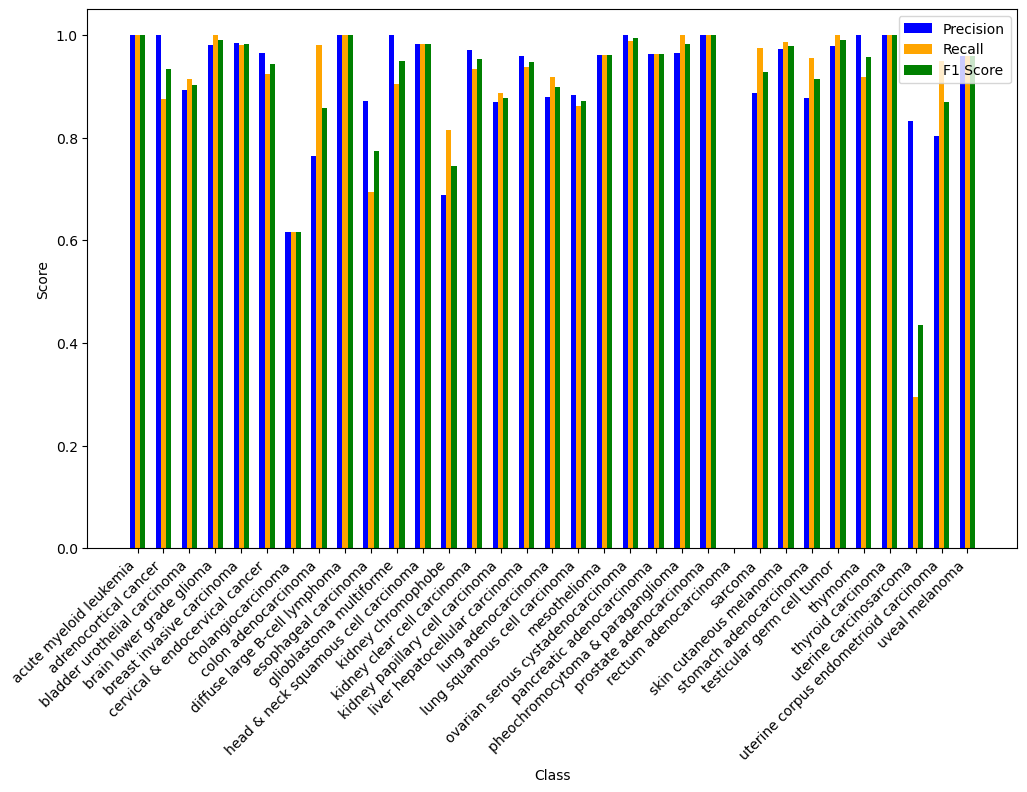

In [18]:
import matplotlib.pyplot as plt

df = class_report['RandomForest'].iloc[:33]
df.index = range(33)


plt.figure(figsize=(12, 7))
width = 0.2 

plt.bar(df.index - width, df['precision'], width, label='Precision', color='blue')
plt.bar(df.index, df['recall'], width, label='Recall', color='orange')
plt.bar(df.index + width, df['f1-score'], width, label='F1 Score', color='green')

plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(df.index, lb.inverse_transform(df.index), rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.05)

plt.show()

## Xử lý mất cân bằng

In [6]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import numpy as np

def handle_imbalanced_data(X_train, y_train, max_samples_per_class):
    
    class_counts = Counter(y_train)
    classes_to_increase = [label for label, count in class_counts.items() if count < max_samples_per_class]
    smote = SMOTE(sampling_strategy={label: max_samples_per_class for label in classes_to_increase}, k_neighbors=3, random_state=42)

    classes_to_reduce = [label for label, count in class_counts.items() if count > max_samples_per_class]
    random_undersampler = RandomUnderSampler(sampling_strategy={label: max_samples_per_class for label in classes_to_reduce}, random_state=42)

    X_resampled, y_resampled = smote.fit_resample(X_train.values, y_train)

    X_final, y_final = random_undersampler.fit_resample(X_resampled, y_resampled)


    return X_final, y_final





In [8]:
X_train_balenced, y_bealenced = handle_imbalanced_data(X_train, y_train, 260)

Số lượng mẫu trước khi xử lý: Counter({4: 853, 13: 424, 16: 403, 29: 400, 11: 396, 17: 387, 22: 385, 3: 371, 25: 332, 26: 315, 2: 298, 15: 296, 7: 230, 14: 226, 5: 216, 19: 216, 24: 185, 31: 141, 9: 137, 21: 131, 20: 128, 0: 121, 10: 120, 27: 109, 28: 85, 23: 74, 12: 64, 18: 61, 32: 56, 1: 55, 30: 40, 8: 34, 6: 32})
Số lượng mẫu sau khi xử lý: Counter({0: 260, 1: 260, 2: 260, 3: 260, 4: 260, 5: 260, 6: 260, 7: 260, 8: 260, 9: 260, 10: 260, 11: 260, 12: 260, 13: 260, 14: 260, 15: 260, 16: 260, 17: 260, 18: 260, 19: 260, 20: 260, 21: 260, 22: 260, 23: 260, 24: 260, 25: 260, 26: 260, 27: 260, 28: 260, 29: 260, 30: 260, 31: 260, 32: 260})


In [27]:
res, class_report = optimizer_ml(X_train_balenced, X_test.values, y_bealenced, y_test, models, param_grids)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [31]:
res1 = res.transpose()

In [35]:
res1.columns = res1.iloc[0]
res1.drop('Model', axis=0, inplace=True)

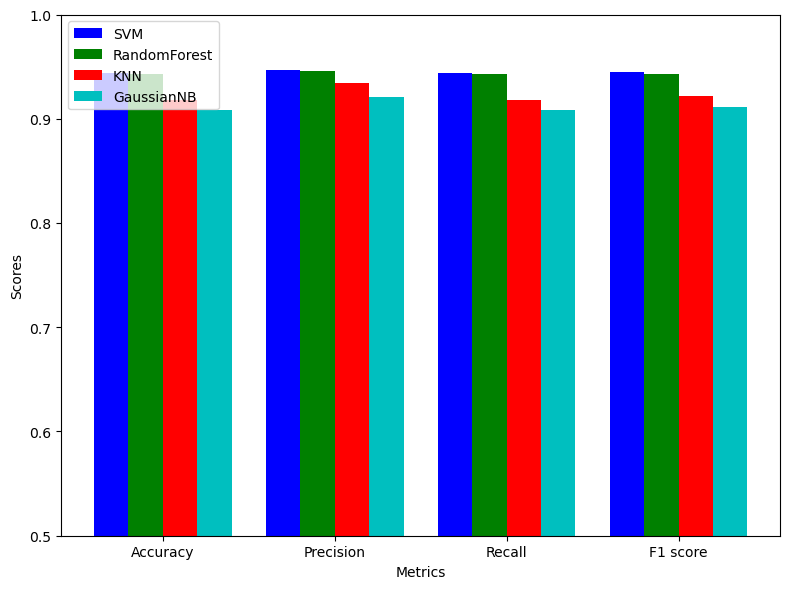

In [36]:
import matplotlib.pyplot as plt
import numpy as np
res = res1
plt.figure(figsize=(8, 6))
bar_width = 0.2
x = np.arange(len(res.index))  

plt.bar(x, res['SVM'], width=bar_width, label='SVM', color='b', align='center')
plt.bar(x + bar_width, res['RandomForest'], width=bar_width, label='RandomForest', color='g', align='center')
plt.bar(x + 2 * bar_width, res['KNN'], width=bar_width, label='KNN', color='r', align='center')
plt.bar(x + 3 * bar_width, res['GaussianNB'], width=bar_width, label='GaussianNB', color='c', align='center')


plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(x + 1.5 * bar_width, res.index) 
plt.ylim(0.5, 1)
plt.legend()


plt.tight_layout()

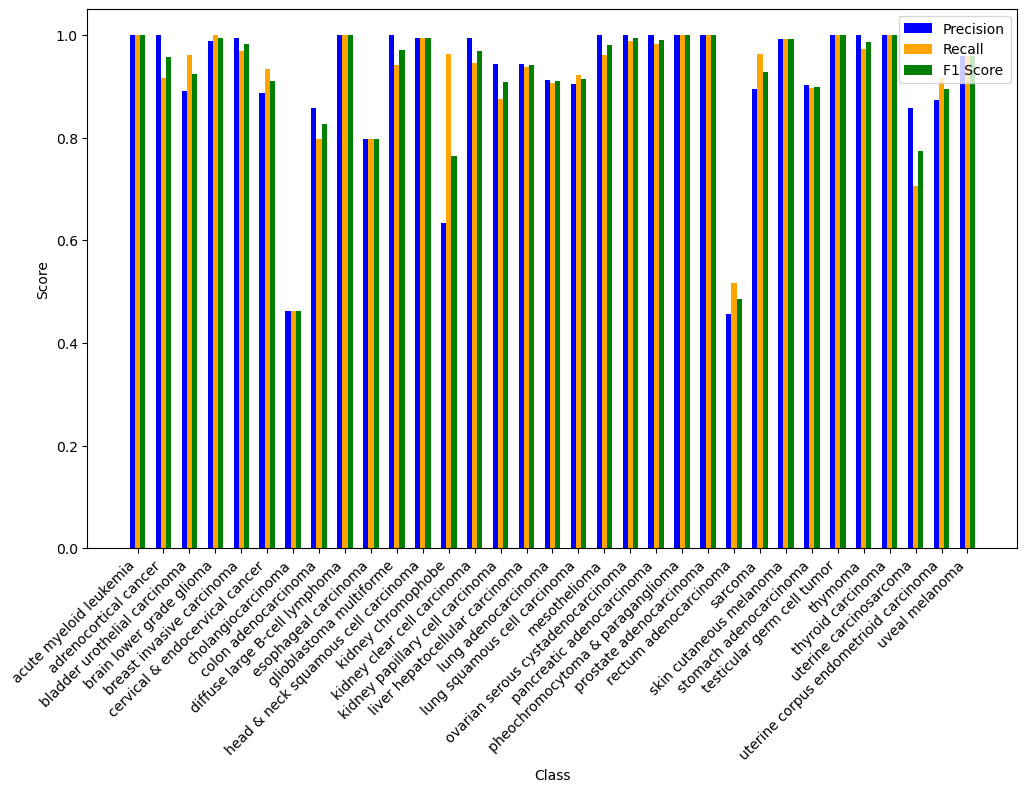

In [37]:
import matplotlib.pyplot as plt

df = class_report['SVM'].iloc[:33]
df.index = range(33)


plt.figure(figsize=(12, 7))
width = 0.2 

plt.bar(df.index - width, df['precision'], width, label='Precision', color='blue')
plt.bar(df.index, df['recall'], width, label='Recall', color='orange')
plt.bar(df.index + width, df['f1-score'], width, label='F1 Score', color='green')

plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(df.index, lb.inverse_transform(df.index), rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.05)

plt.show()

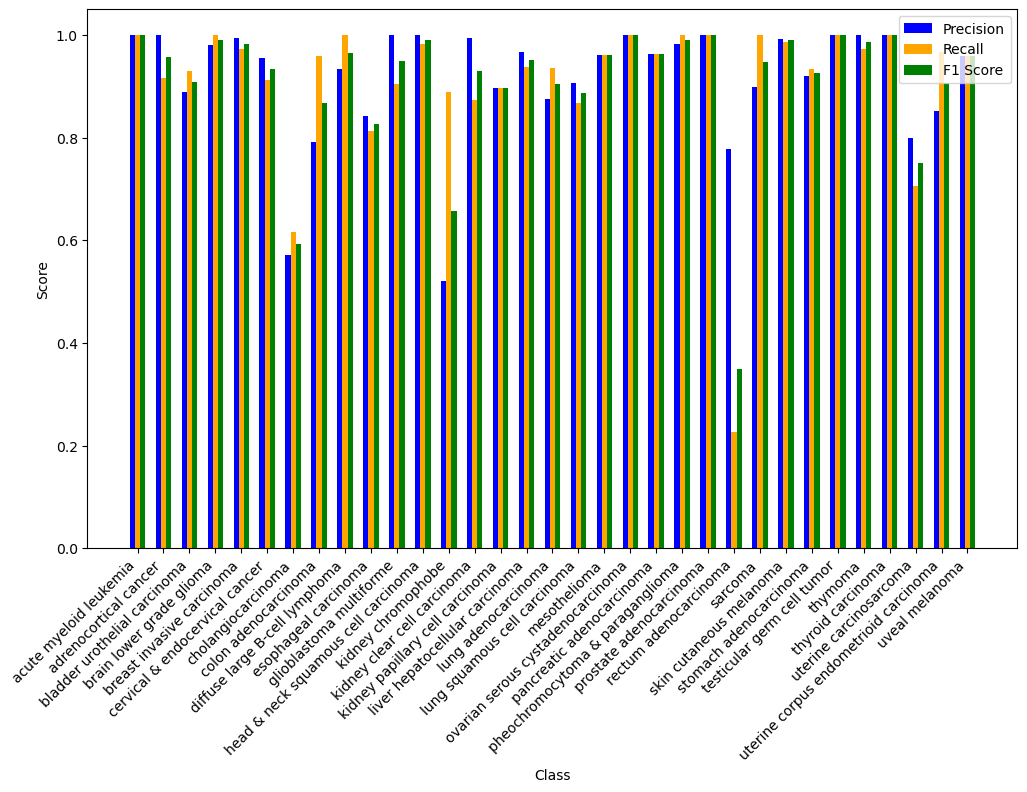

In [14]:
import matplotlib.pyplot as plt

df = class_report['RandomForest'].iloc[:33]
df.index = range(33)


plt.figure(figsize=(12, 7))
width = 0.2 

plt.bar(df.index - width, df['precision'], width, label='Precision', color='blue')
plt.bar(df.index, df['recall'], width, label='Recall', color='orange')
plt.bar(df.index + width, df['f1-score'], width, label='F1 Score', color='green')

plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(df.index, lb.inverse_transform(df.index), rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.05)

plt.show()

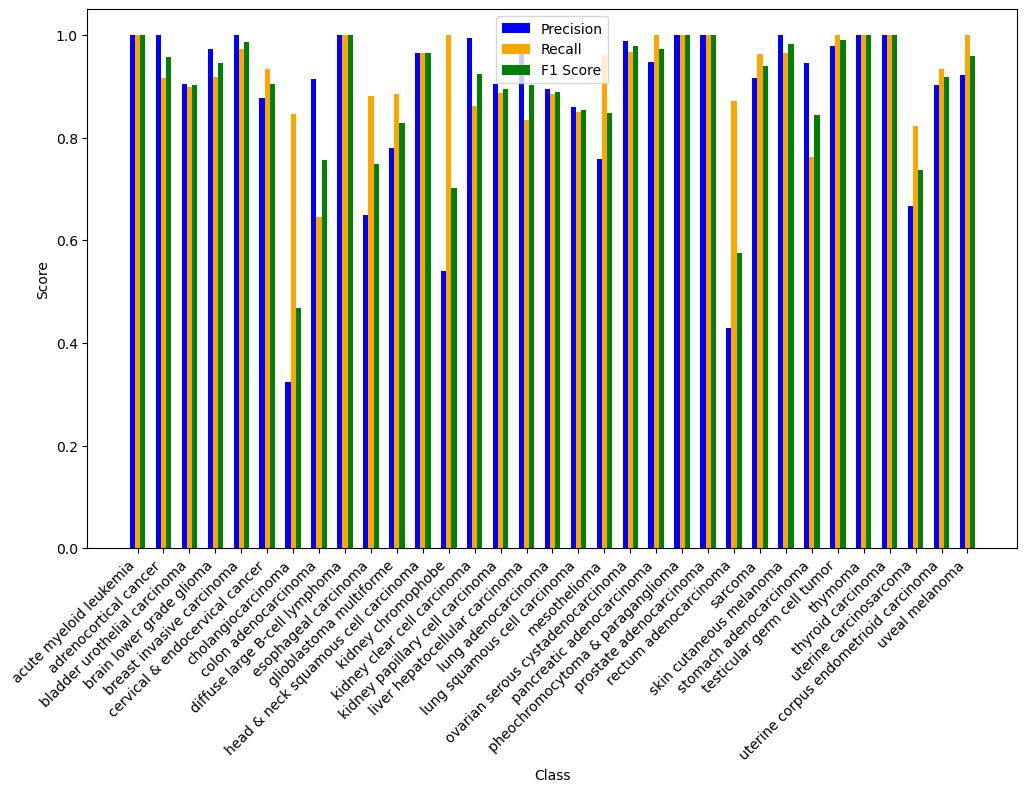

In [38]:
import matplotlib.pyplot as plt

df = class_report['KNN'].iloc[:33]
df.index = range(33)


plt.figure(figsize=(12, 7))
width = 0.2 

plt.bar(df.index - width, df['precision'], width, label='Precision', color='blue')
plt.bar(df.index, df['recall'], width, label='Recall', color='orange')
plt.bar(df.index + width, df['f1-score'], width, label='F1 Score', color='green')

plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(df.index, lb.inverse_transform(df.index), rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.05)

plt.show()

In [17]:
res

,Model,Accuracy,Precision,Recall,F1 score
0,SVM,0.942320,0.944590,0.942320,0.942834
1,RandomForest,0.942320,0.946040,0.942320,0.941422
2,KNN,0.913958,0.934244,0.913958,0.918462
3,GaussianNB,0.908540,0.921282,0.908540,0.911838


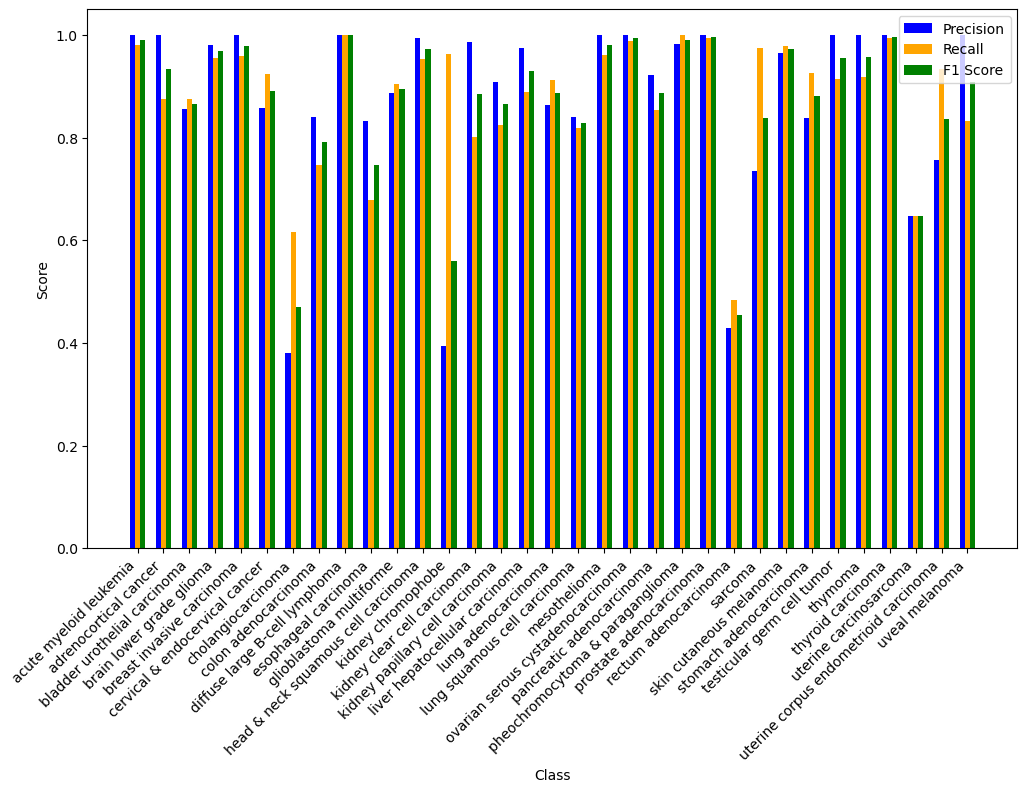

In [39]:
import matplotlib.pyplot as plt

df = class_report['GaussianNB'].iloc[:33]
df.index = range(33)


plt.figure(figsize=(12, 7))
width = 0.2 

plt.bar(df.index - width, df['precision'], width, label='Precision', color='blue')
plt.bar(df.index, df['recall'], width, label='Recall', color='orange')
plt.bar(df.index + width, df['f1-score'], width, label='F1 Score', color='green')

plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(df.index, lb.inverse_transform(df.index), rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.05)

plt.show()

In [10]:
import numpy as np

index_cancer, values_count = np.unique(y_train, return_counts=True)
index_cancer1_bl, values_count_bl = np.unique(y_bealenced, return_counts=True)

In [11]:
sum(values_count)

7321

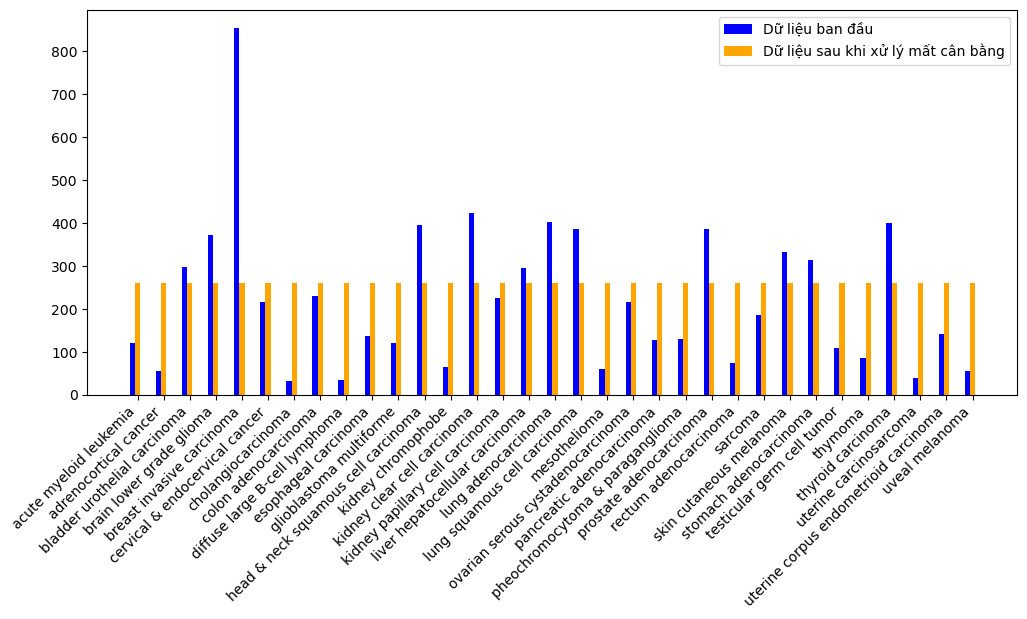

In [13]:
import matplotlib.pyplot as plt

width = 0.2 
plt.figure(figsize=(12, 5))
plt.bar(index_cancer - width, values_count, width=width, label='Dữ liệu ban đầu', color='blue')
plt.bar(index_cancer, values_count_bl, width=width, label='Dữ liệu sau khi xử lý mất cân bằng', color='orange')
plt.xticks(index_cancer, lb.inverse_transform(index_cancer),rotation=45, ha='right') 
plt.legend()

In [2]:
data = pd.read_csv(r'..\GDCdata\data_30_cancer.csv')


In [3]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

X = data.drop(columns=['Unnamed: 0', '_primary_disease'])
y = data['_primary_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)


In [4]:
import joblib
lasso_cv = joblib.load('../GDCdata/data_processed/lasso/lasso_model_2.pkl')

d:\ancocda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(lasso_cv, prefit=True, threshold=0.05) 
selected_features_mask = sfm.get_support()

In [6]:

X_train_selected = X_train.loc[:, selected_features_mask[1:]]
X_test_selected = X_test.loc[:, selected_features_mask[1:]]

In [7]:
X_train, y_train = handle_imbalanced_data(X_train_selected, y_train,)

In [10]:
import numpy as np

index_cancer, values_count = np.unique(y_train, return_counts=True)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'acute myeloid leukemia'),
  Text(1, 0, 'adrenocortical cancer'),
  Text(2, 0, 'bladder urothelial carcinoma'),
  Text(3, 0, 'brain lower grade glioma'),
  Text(4, 0, 'breast invasive carcinoma'),
  Text(5, 0, 'cervical & endocervical cancer'),
  Text(6, 0, 'cholangiocarcinoma'),
  Text(7, 0, 'colon adenocarcinoma'),
  Text(8, 0, 'diffuse large B-cell lymphoma'),
  Text(9, 0, 'esophageal carcinoma'),
  Text(10, 0, 'glioblastoma multiforme'),
  Text(11, 0, 'head & neck squamous cell carcinoma'),
  Text(12, 0, 'kidney chromophobe'),
  Text(13, 0, 'kidney clear cell carcinoma'),
  Text(14, 0, 'kidney papillary cell carcinoma'),
  Text(15, 0, 'liver hepatocellular carcinoma'),
  Text(16, 0, 'lung adenocarcinoma'),
  Text(17, 0, 'lung squamous cell carcinoma'),
  Text(18, 0, 'mesothelioma'),


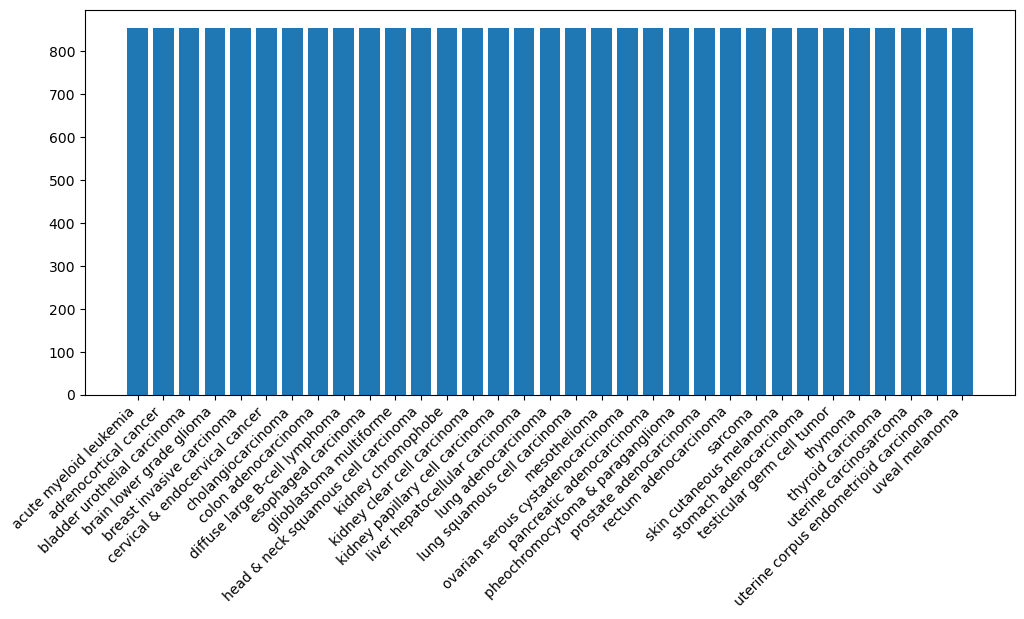

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.bar(lb.inverse_transform(index_cancer), values_count)
plt.xticks(rotation=45, ha='right') 